In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import groupby
%matplotlib inline

In [2]:
!pwd

/home/qbio1/kangjunseo/tutorials


## 1. Figure S2A

In [283]:
### functions ###

## calculate header length, but in this file, header was 0
def cal_header_len(code):
    header = 0
    with open(f"alignment/{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): header+=1
            else: continue
    return header
    

## read sam file using chunk
## also this does basic parsing
def read_sam_by_chunk(code, header=0, chunksize=10**5):
    df = pd.DataFrame()
    for cnt, chunk in enumerate(pd.read_csv(f"alignment/{code}/Aligned.out.sam", header=header, sep='\t', chunksize=chunksize)):
        chunk.iloc[:,3] = chunk.iloc[:,3].astype(int)
        chunk = chunk[(chunk.iloc[:,3]>48689480) & (chunk.iloc[:,3]<48689530)]
        if not chunk.empty: df = pd.concat([df,chunk])
        if cnt%10==0: print(cnt, end = ' ')
    return df


## parse dataframe more to analyze
def parse_df(df):
    df.columns = ['read', 'flag', 'chr', 'pos', 'map_qual', 'cigar', 'rnext', 'pnext', 'tlen', 'seq', 'qual',1,2,3,4]
    df_map = df[df['chr']=='chr13'][['pos','cigar','seq']]
    df_map = df_map[~df_map['cigar'].str.contains('S|I')]
    df_map.index = range(225)
    return df_map


## modify sequence using cigar string, add deletion as 'D'
def add_del(df_map):
    add_del_seq = []
    for row in df_map.itertuples():
        if row.cigar.find('D')==-1:
            add_del_seq.append(row.seq)
        else:
            flag = int(row.cigar[:2])
            add_del_seq.append(row.seq[:flag] + 'D' + row.seq[flag:])
        
    add_del_seq_df = pd.Series(add_del_seq)
    df_map = pd.concat([df_map, add_del_seq_df], axis=1)
    df_map = df_map.drop(labels='seq',axis=1)
    df_map.columns = ['pos', 'cigar', 'seq']
    return df_map
    
    
## calculate shannon entropy
def shannon(seq, base):
    p = seq.count(base)/len(seq) 
    return 0 if (p==0 or p==1) else (-p*np.log2(p) -(1-p)*np.log2(1-p))

In [250]:
df_map = add_del(parse_df(read_sam_by_chunk("CLIP_35L33G")))
df_map

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 

,pos,cigar,seq
0,48689514,14M1D64M,TCGTATAGTTAACTDCTTGTGGGCAAAATCTCTGCCCTAAAACTAT...
1,48689491,37M1D23M,AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTGGG...
2,48689489,39M1D23M,ATAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTG...
3,48689502,30M,AAAGGCAGCAGGTCGTATAGTTAACTCCTT
4,48689502,30M,AAAGGCAGCAGGTCGTATAGTTAACTCGTT
...,...,...,...
220,48689514,14M1D64M,TCGTATAGTTAACTDCTTGTGGGCAAAATCTCTGCCCTAAAACTAT...
221,48689515,78M,CGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCCTAAAACTATG...
222,48689490,62M,TAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCTTTGTGG...
223,48689491,37M1D23M,AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTGGG...


In [237]:
pos_map = defaultdict(str)
for row in df_map.itertuples():
    for idx, base in enumerate(row.seq):
        pos_map[idx+row.pos]+=base

In [275]:
ref_seq = "TAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCC"
x_axis = range(48689490,48689551)
y_axis = []
for idx, pos in enumerate(x_axis):
    y_axis.append(shannon(pos_map[pos],ref_seq[idx]))

Text(48689529, 1.1224491812352424, '0.9924')

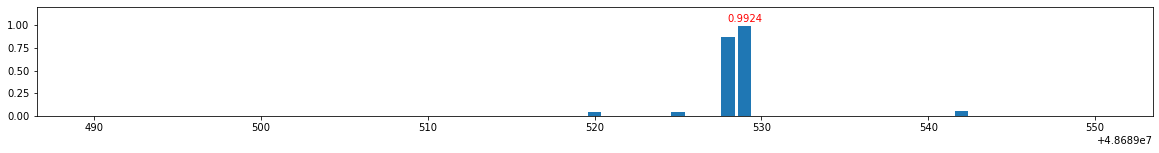

In [276]:
dic = { y:x for x, y in zip(x_axis, y_axis) }
plt.figure(figsize=(20,2))
plt.bar(x_axis,y_axis)
plt.ylim(0,1.2)
plt.text(dic[max(y_axis)],0.13+max(y_axis),
         str(round(max(y_axis),4)),
         color='r',
         horizontalalignment='center',
         verticalalignment='top')

## 2. Figure S2C

In [5]:
def fasta_iter(path):
    fh = open(path)
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in faiter:
        head = header.__next__()[1:].strip().split()[0]
        seq = "".join(s.strip() for s in faiter.__next__())
        yield head, seq
        
        
def read_sam_by_chunk2(code, header=0, chunksize=10**5):
    df = pd.DataFrame()
    for cnt, chunk in enumerate(pd.read_csv(f"alignment/{code}/Aligned.out.sam", header=header, sep='\t', chunksize=chunksize)):
        chunk.columns=['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','TLEN','SEQ','QUAL',1,2,3,4]
        chunk = chunk[chunk['FLAG']!='4'][['RNAME','POS','CIGAR','SEQ']]
        chunk = chunk[~chunk['CIGAR'].str.contains('S')]
        if not chunk.empty: df = pd.concat([df,chunk])
        if cnt%10==0: print(cnt, end = ' ')
    return df


def parse_cigar(cigar):
    cigar_map = []
    tmp = ''
    D, I = 0, 0
    for i in cigar:
        if i.isnumeric(): tmp+=i
        else: 
            cigar_map.append((i,int(tmp)))
            if i == 'D': D+=int(tmp)
            elif i =='I': I+=int(tmp)
            tmp = ''
            
    return cigar_map, D, I


def sub_table(df, trans_dict, gene_dict):
    sub_map = [[0 for _ in range(4)] for _ in range(20)]
    smap = {'A':0, 'T':1, 'G':2, 'C':3}

    for cnt, row in enumerate(CLIP_df.itertuples()):
        if cnt%200000==0 : print(int(cnt/665000), end=' ')
        pos = int(row.POS)-1
        cur_pos = 0
        L = len(row.SEQ)
        cigar, D, I = parse_cigar(row.CIGAR)
        refseq = trans_dict[row.RNAME] if row.RNAME.startswith("EN") else gene_dict[row.RNAME]

        for flag, cnt in cigar:
            if flag == 'D' or flag == 'N': pos+=cnt
            elif flag == 'I': cur_pos+=cnt
            else:  #'M'
                while cnt:
                    if row.SEQ[cur_pos] != refseq[pos]: sub_map[int(cur_pos/L*20)][smap[refseq[pos]]]+=1 
                    cur_pos+=1
                    pos+=1
                    cnt-=1
                
    sub_df = pd.DataFrame(sub_map)
    sub_df.columns = smap.keys()
    sub_df['Total'] = sub_df['A'] + sub_df['T'] + sub_df['G'] + sub_df['C']

    return sub_df

In [6]:
CLIP_df = read_sam_by_chunk2("CLIP_35L33G")
CLIP_df

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 

,RNAME,POS,CIGAR,SEQ
0,chr11,106143514,50M,GCTCTTTCAGCTTCTTAGCCACATATCGCCGAAGCTTTGTTCTCCA...
1,chr14,63761346,35M,GAGTGACTGCCACCTTGCAGTGCTTAGAAGGCCAT
2,ENSMUST00000058679.7|ENSMUSG00000035078.7|OTTM...,2116,35M,ATGGCCTTCTAAGCACTGCAAGGTGGCAGTCACTC
3,chr11,86602336,28M,TGAGTAGCAGGCTCCTCACAGCCCTCAT
4,ENSMUST00000103186.11|ENSMUSG00000047126.18|OT...,2876,28M,ATGAGGGCTGTGAGGAGCCTGCTACTCA
...,...,...,...,...
81496234,ENSMUST00000151431.2|ENSMUSG00000078970.6|OTTM...,869,12M1D16M,GGAATTGGGGAAGAGCCCCTGAAATCGT
81496235,ENSMUST00000046955.7|ENSMUSG00000078970.6|OTTM...,416,12M1D16M,GGAATTGGGGAAGAGCCCCTGAAATCGT
81496236,chr11,17172282,12M1D16M,GGAATTGGGGAAGAGCCCCTGAAATCGT
81496237,chr17,40158384,37M,GCTTCCGGGAAACCAAAGTCTTTGGGTTCCGGGGGGA


In [ ]:
CLIP_df.drop_duplicates(subset=['SEQ'], inplace=True)

In [7]:
# "ref_gene/GRCm39.primary_assembly.genome.fa"
# "ref_gene/gencode.vM29.transcripts.fa"
trans_dict = {ff[0] : ff[1] for ff in fasta_iter("ref_gene/gencode.vM29.transcripts.fa")}
gene_dict = {ff[0] : ff[1] for ff in fasta_iter("ref_gene/GRCm39.primary_assembly.genome.fa")}

In [71]:
CLIP_df

,RNAME,POS,CIGAR,SEQ
0,chr11,106143514,50M,GCTCTTTCAGCTTCTTAGCCACATATCGCCGAAGCTTTGTTCTCCA...
1,chr14,63761346,35M,GAGTGACTGCCACCTTGCAGTGCTTAGAAGGCCAT
2,ENSMUST00000058679.7|ENSMUSG00000035078.7|OTTM...,2116,35M,ATGGCCTTCTAAGCACTGCAAGGTGGCAGTCACTC
3,chr11,86602336,28M,TGAGTAGCAGGCTCCTCACAGCCCTCAT
4,ENSMUST00000103186.11|ENSMUSG00000047126.18|OT...,2876,28M,ATGAGGGCTGTGAGGAGCCTGCTACTCA
...,...,...,...,...
81495943,chr3,60565226,22M202680N23M,AATTTTTTTTTTTTTTTTTTTTTTTCCTTCTGAAGGTTTTACGAT
81495970,chr9,70466321,47M,AAAAAACAAGAAGCGGATGAGTTGAGTAGAGATGCTTCTGTGGAAGA
81496029,ENSMUST00000058889.5|ENSMUSG00000055884.9|OTTM...,2324,40M,ATGAAAATGATAGAAGGAATGAGACACGAAGAGGGCGAAT
81496071,chr3,151998222,78M,ACACTTCTTTCATCCGCTCCTCAGTGGCAGGCACTGATCTCCCCAT...


In [8]:
sub_map = [[0 for _ in range(4)] for _ in range(20)]
smap = {'A':0, 'T':1, 'G':2, 'C':3}

for cnt, row in enumerate(CLIP_df.itertuples()):
    if cnt%200000==0 : print(int(cnt/665000), end=' ')
    pos = int(row.POS)-1
    cur_pos = 0
    L = len(row.SEQ)
    cigar, D, I = parse_cigar(row.CIGAR)
    refseq = trans_dict[row.RNAME] if row.RNAME.startswith("EN") else gene_dict[row.RNAME]

    for flag, cnt in cigar:
        if flag == 'D' or flag == 'N': 
            pos+=cnt
        elif flag == 'I':
            cur_pos+=cnt
        else:  #'M'
            while cnt:
                if row.SEQ[cur_pos] != refseq[pos]: sub_map[int(cur_pos/L*20)][smap[refseq[pos]]]+=1 
                cur_pos+=1
                pos+=1
                cnt-=1
                
sub_df = pd.DataFrame(sub_map)
sub_df.columns = smap.keys()
sub_df['Total'] = sub_df['A'] + sub_df['T'] + sub_df['G'] + sub_df['C']

sub_dftrans_dict

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

,A,T,G,C,Total
0,22738,18690,87908,36724,166060
1,126609,83424,639737,166194,1015964
2,113355,111196,898090,267147,1389788
3,142936,92414,910650,262197,1408197
4,134742,102661,1042155,280012,1559570
5,84794,90337,1235865,322193,1733189
6,88033,83135,1293301,341999,1806468
7,109561,85983,1714909,356774,2267227
8,88026,109243,1921311,499931,2618511
9,77707,98864,1302739,372311,1851621


In [9]:
total = sum([len(row.SEQ) for row in CLIP_df.itertuples()])

In [10]:
sub_df['percent'] = sub_df['Total']/total*100*20
sub_df

,A,T,G,C,Total,percent
0,22738,18690,87908,36724,166060,0.128754
1,126609,83424,639737,166194,1015964,0.787725
2,113355,111196,898090,267147,1389788,1.077569
3,142936,92414,910650,262197,1408197,1.091842
4,134742,102661,1042155,280012,1559570,1.209209
5,84794,90337,1235865,322193,1733189,1.343824
6,88033,83135,1293301,341999,1806468,1.400640
7,109561,85983,1714909,356774,2267227,1.757889
8,88026,109243,1921311,499931,2618511,2.030256
9,77707,98864,1302739,372311,1851621,1.435650


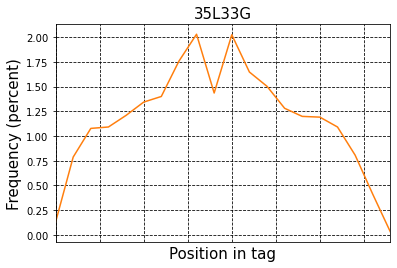

In [32]:
plt.title("35L33G", fontsize=15)
plt.plot(sub_df['percent'] , 'C1')
plt.grid(linestyle = '--', color = 'black')
plt.xlim([0,19])
plt.xlabel('Position in tag', fontsize=15)
plt.ylabel('Frequency (percent)', fontsize=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

## 3. Figure S3C, Figure 2A

In [4]:
def pos_table(code, header=0, chunksize=10**5):
    table = defaultdict(str)
    for cnt, chunk in enumerate(pd.read_csv(f"alignment/{code}/Aligned.out.sam", header=header, sep='\t', chunksize=chunksize)):
        chunk.iloc[:,3] = chunk.iloc[:,3].astype(int)
        chunk = chunk.drop(chunk.iloc[:,10:],axis=1).drop(chunk.iloc[:,4:9],axis=1).drop(chunk.iloc[:,:3],axis=1)
        chunk.columns = ['pos','seq']
        
        for row in chunk.itertuples():
            for idx, base in enumerate(row.seq):
                table[row.pos+idx]+=base
                
        if cnt%10==0: print(cnt, end = ' ')
        if cnt==500: break
    return table

In [ ]:
pos_t = pos_table("CLIP_35L33G")
pos_t

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 

In [ ]:
pos_t.columns = ['pos','seq']
for cnt, row in enumerate(pos_t.itertuples()):
    for idx, base in enumerate(row.seq):
        table[row.pos+idx][base]+=1
    if cnt%1000000==0: print(cnt, end=' ')
    